In [2]:
!pip install pandas

In [8]:
import pandas as pd

# Use the full path to your file. The 'r' before the string is important.
# Example: r'C:\Users\YourUsername\Documents\your_file.xlsx'
file_path = r"C:\Users\karan\OneDrive\Desktop\GitHub Projects\delhi_ai_course_student_feedback_1000.xlsx"

df = pd.read_excel(file_path)

print(df.head())

   rating                                      feedback_text
0       5  Clear introductions with practical examples; l...
1       4  Comprehensive content and strong hands-on proj...
2       3  Good pace but the modules could be better orga...
3       5  Excellent content with practical NLP workflows...
4       4  Thoughtful coverage of ethical considerations ...


In [9]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# --- Step 1: Remove missing rows ---
# This operation removes any row where 'feedback_text' is empty.
# The .copy() is used to avoid a common pandas warning.
df_cleaned = df.dropna(subset=['feedback_text']).copy()


# --- Step 2: Make text lowercase ---
# Creates a new column 'lowercase_text'
df_cleaned['lowercase_text'] = df_cleaned['feedback_text'].str.lower()


# --- Step 3: Remove special characters ---
# This keeps only letters and spaces.
# Creates a new column 'no_special_chars'
df_cleaned['no_special_chars'] = df_cleaned['lowercase_text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)


# --- Step 4: Tokenize text ---
# Tokenization splits a sentence into a list of individual words.
# Creates a new column 'tokenized_text'
df_cleaned['tokenized_text'] = df_cleaned['no_special_chars'].apply(word_tokenize)


# --- Step 5: Remove stopwords ---
# Stopwords are common words (like "the", "is", "in") that often don't carry significant meaning.
# Creates a new column 'final_processed_text'
stop_words = set(stopwords.words('english'))

df_cleaned['final_processed_text'] = df_cleaned['tokenized_text'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)

# --- Display the first 5 rows with all the new columns ---
print(df_cleaned[['feedback_text', 'lowercase_text', 'no_special_chars', 'tokenized_text', 'final_processed_text']].head())

                                       feedback_text  \
0  Clear introductions with practical examples; l...   
1  Comprehensive content and strong hands-on proj...   
2  Good pace but the modules could be better orga...   
3  Excellent content with practical NLP workflows...   
4  Thoughtful coverage of ethical considerations ...   

                                      lowercase_text  \
0  clear introductions with practical examples; l...   
1  comprehensive content and strong hands-on proj...   
2  good pace but the modules could be better orga...   
3  excellent content with practical nlp workflows...   
4  thoughtful coverage of ethical considerations ...   

                                    no_special_chars  \
0  clear introductions with practical examples lo...   
1  comprehensive content and strong handson proje...   
2  good pace but the modules could be better orga...   
3  excellent content with practical nlp workflows...   
4  thoughtful coverage of ethical consideratio

In [11]:
from textblob import TextBlob

# --- Step 1: Prepare the text for TextBlob ---
# The 'final_processed_text' column currently contains lists of words (tokens).
# TextBlob requires a single string as input. We must join the tokens back together.
# We create a temporary column for this.
df_cleaned['text_for_sentiment'] = df_cleaned['final_processed_text'].apply(lambda tokens: ' '.join(tokens))

# --- Step 2: Define functions for sentiment analysis ---

def get_sentiment_score(text):
    """
    Calculates the polarity score.
    Returns a float between -1.0 (most negative) and 1.0 (most positive).
    """
    return TextBlob(text).sentiment.polarity

def get_sentiment_category(score):
    """
    Categorizes the score into Positive, Negative, or Neutral.
    """
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# --- Step 3: Apply the functions to create new columns ---

# Calculate the score
df_cleaned['sentiment_score'] = df_cleaned['text_for_sentiment'].apply(get_sentiment_score)

# Categorize the score
df_cleaned['sentiment_category'] = df_cleaned['sentiment_score'].apply(get_sentiment_category)


# --- Step 4: Prepare the final DataFrame for export ---
# You requested the original columns plus the two new sentiment columns.
# We get the original column names from the initial 'df' DataFrame.
original_columns = list(df.columns)
final_columns_to_keep = original_columns + ['sentiment_score', 'sentiment_category']

# Select only the requested columns from our cleaned DataFrame
df_final = df_cleaned[final_columns_to_keep]


# --- Step 5: Export to a new Excel file ---
output_filename = 'sentiment_analysis_results.xlsx'
# index=False prevents pandas from writing the row numbers as the first column in Excel
df_final.to_excel(output_filename, index=False)

print(f"Sentiment analysis complete. File saved successfully as '{output_filename}'")
print(df_final.head())

Sentiment analysis complete. File saved successfully as 'sentiment_analysis_results.xlsx'
   rating                                      feedback_text  sentiment_score  \
0       5  Clear introductions with practical examples; l...         0.400000   
1       4  Comprehensive content and strong hands-on proj...         0.066667   
2       3  Good pace but the modules could be better orga...         0.412500   
3       5  Excellent content with practical NLP workflows...         1.000000   
4       4  Thoughtful coverage of ethical considerations ...         0.150000   

  sentiment_category  
0           Positive  
1           Positive  
2           Positive  
3           Positive  
4           Positive  


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

# --- Step 1: Prepare the text data ---
# NMF requires numerical input, so we'll use a TF-IDF vectorizer.
# The input for the vectorizer needs to be strings, not lists of tokens.
# We will join the tokens from 'final_processed_text' back into sentences.
df_cleaned['text_for_topic_modeling'] = df_cleaned['final_processed_text'].apply(lambda tokens: ' '.join(tokens))

# --- Step 2: Create the TF-IDF Matrix ---
# TfidfVectorizer converts the text into a matrix of TF-IDF features.
# max_df=0.95 ignores terms that appear in more than 95% of the documents (too common).
# min_df=2 ignores terms that appear in less than 2 documents (too rare).
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_cleaned['text_for_topic_modeling'])

# --- Step 3: Apply NMF ---
# We create and fit the NMF model.
num_topics = 5
# random_state ensures the results are reproducible.
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# --- Step 4: Display the topics ---
# For each topic, we will show the top 10 most important words.
feature_names = tfidf_vectorizer.get_feature_names_out()
num_top_words = 10

print("Discovered Topics:\n")
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic {topic_idx + 1}: {' | '.join(top_words)}")

# --- Step 5 (Optional but Recommended): Assign a topic to each feedback entry ---
# We can find out which topic is most dominant for each piece of feedback.
topic_results = nmf_model.transform(tfidf_matrix)
# .argmax(axis=1) finds the index (topic number) of the highest score for each row.
df_cleaned['topic'] = topic_results.argmax(axis=1)

# Display the head of the DataFrame with the new 'topic' column
print("\nDataFrame with assigned topics:")
print(df_cleaned[['feedback_text', 'topic']].head())

Discovered Topics:

Topic 1: felt | help | modules | content | good | rushed | pacing | solid | repetitive | overall
Topic 2: case | studies | discussions | thoughtprovoking | ethical | frameworks | thoughtful | ethics | benefit | content
Topic 3: excellent | projects | mentor | feedback | support | comprehensive | handson | theory | curriculum | project
Topic 4: clear | explanations | practical | course | concepts | datasets | quickly | helped | demos | exercises
Topic 5: topics | advanced | explained | complex | instructor | clarity | depth | instructors | clearly | lagged

DataFrame with assigned topics:
                                       feedback_text  topic
0  Clear introductions with practical examples; l...      3
1  Comprehensive content and strong hands-on proj...      2
2  Good pace but the modules could be better orga...      0
3  Excellent content with practical NLP workflows...      3
4  Thoughtful coverage of ethical considerations ...      1


C:\Users\karan\AppData\Local\Temp\ipykernel_15992\1537615946.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="viridis")


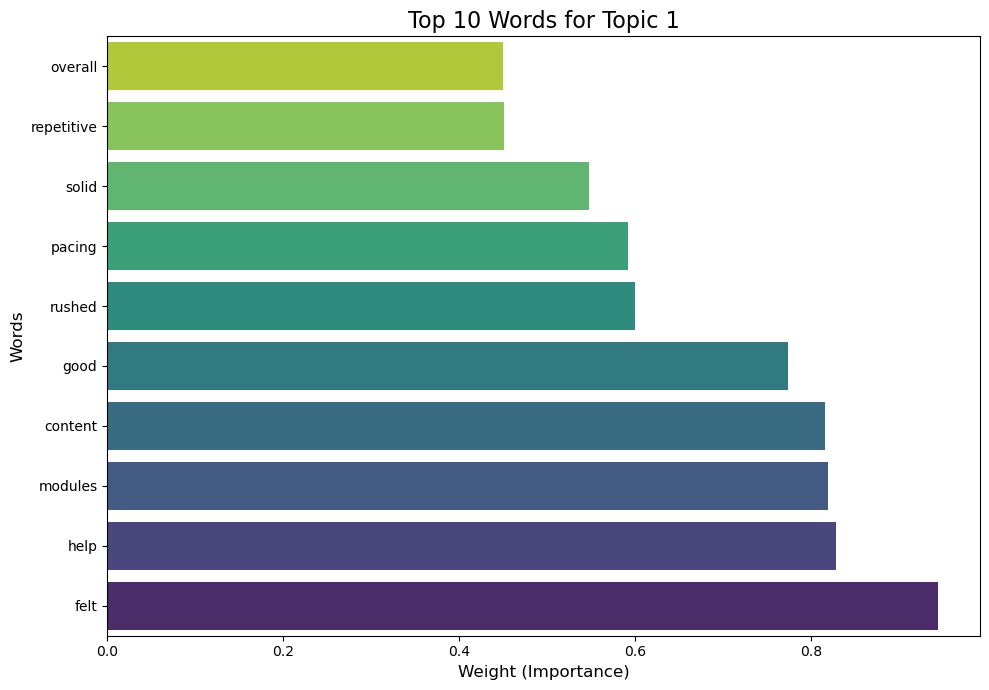

C:\Users\karan\AppData\Local\Temp\ipykernel_15992\1537615946.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="viridis")


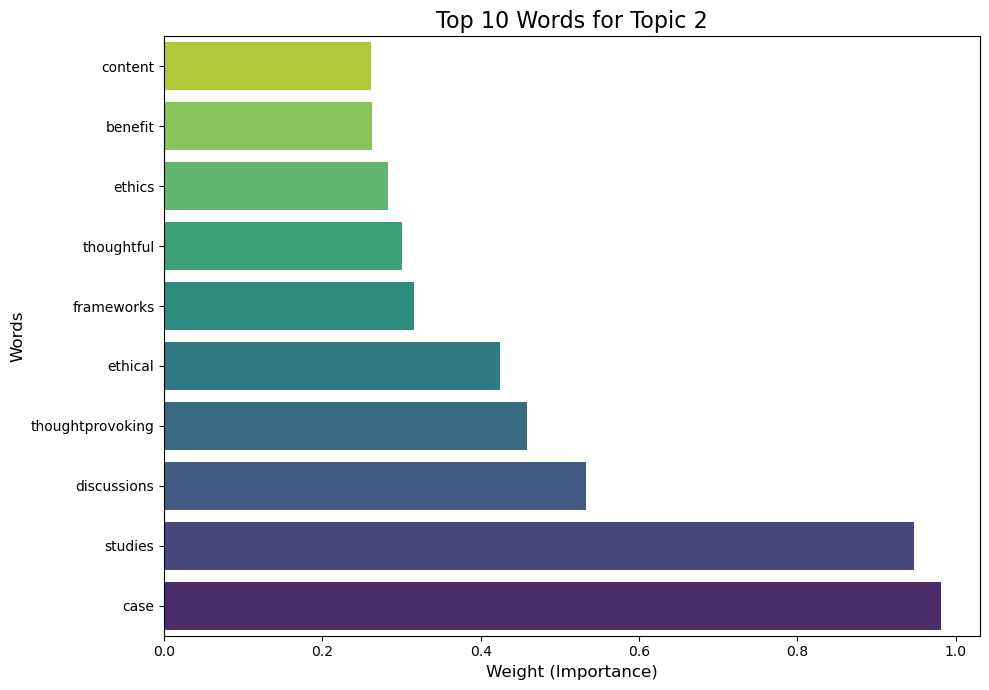

C:\Users\karan\AppData\Local\Temp\ipykernel_15992\1537615946.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="viridis")


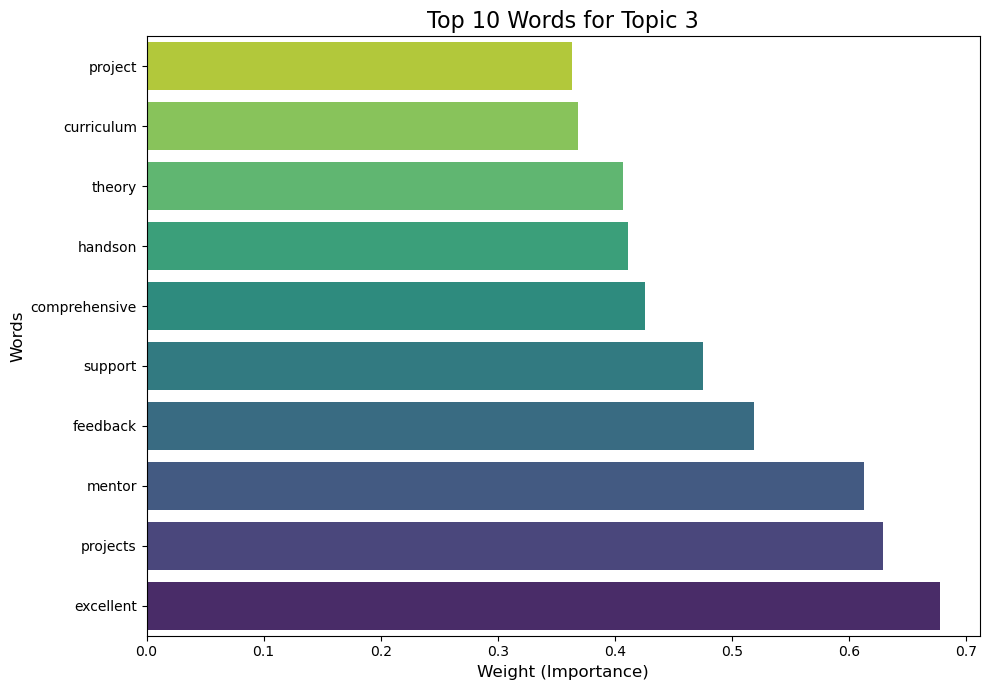

C:\Users\karan\AppData\Local\Temp\ipykernel_15992\1537615946.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="viridis")


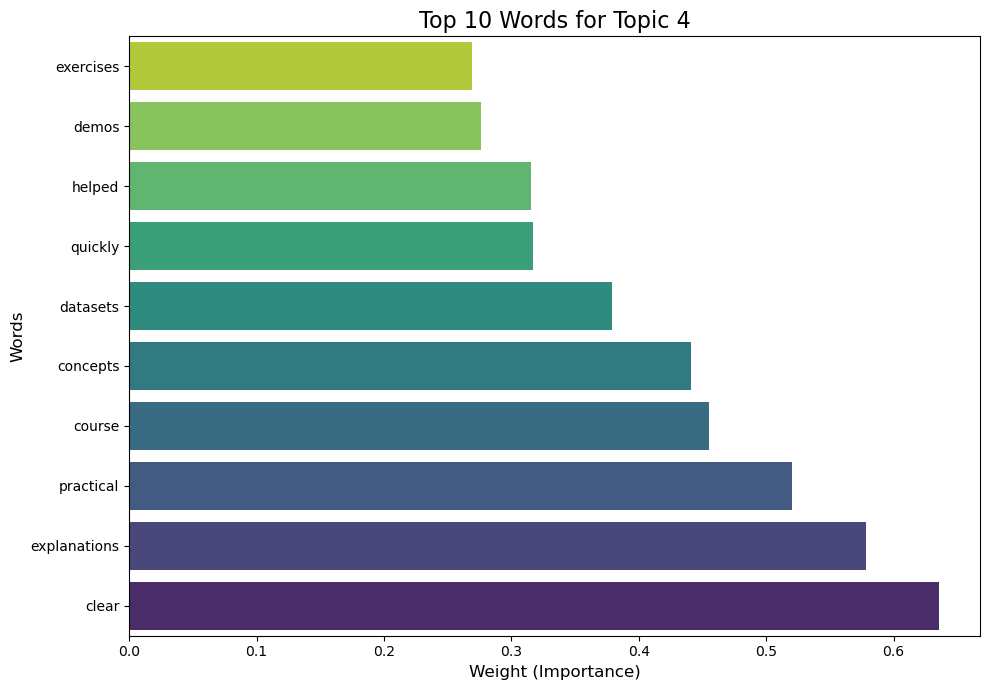

C:\Users\karan\AppData\Local\Temp\ipykernel_15992\1537615946.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="viridis")


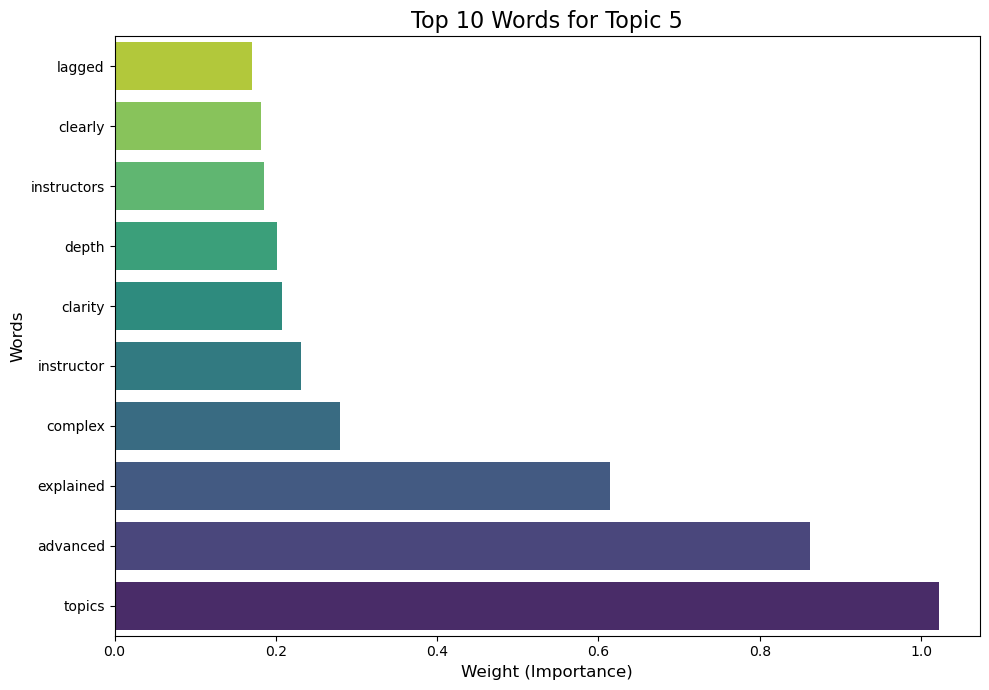

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# This is the number of top words you want to display for each topic
num_top_words = 10

# Get the topic-word distributions from the NMF model
topic_word_distributions = nmf_model.components_

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop through each topic to create and display a bar chart
for topic_idx, topic in enumerate(topic_word_distributions):
    
    # Get the indices of the top N words for this topic
    top_word_indices = topic.argsort()[:-num_top_words - 1:-1]
    
    # Get the top N words and their corresponding weights
    top_words = [feature_names[i] for i in top_word_indices]
    top_weights = [topic[i] for i in top_word_indices]
    
    # --- Create the bar chart ---
    plt.figure(figsize=(10, 7)) # Set the figure size for better readability
    
    # Create the bar plot
    sns.barplot(x=top_weights, y=top_words, palette="viridis")
    
    # Set the title and labels
    plt.title(f'Top {num_top_words} Words for Topic {topic_idx + 1}', fontsize=16)
    plt.xlabel('Weight (Importance)', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    
    # Invert y-axis to have the most important word on top
    plt.gca().invert_yaxis() 
    
    # Ensure the layout is tight
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop through each topic to generate and display a word cloud
for topic_idx, topic in enumerate(nmf_model.components_):
    
    # --- Create a dictionary of words and their weights for the current topic ---
    # The WordCloud object works best with a dictionary of {word: weight}.
    topic_words_weights = {feature_names[i]: topic[i] for i in topic.argsort()}
    
    # --- Create the WordCloud object ---
    # You can customize width, height, background_color, etc.
    wc = WordCloud(
        background_color="white",
        width=800,
        height=600,
        max_words=50  # Controls the maximum number of words to display
    )
    
    # Generate the word cloud from the word weights
    wc.generate_from_frequencies(topic_words_weights)
    
    # --- Display the word cloud using matplotlib ---
    plt.figure(figsize=(10, 7)) # Set the figure size
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f'Word Cloud for Topic {topic_idx + 1}', fontsize=16)
    plt.axis("off") # Hide the axes
    plt.show()